In [1]:
import pandas as pd
import numpy as np
from scipy import stats as sps
import math
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

from utils.extract_data import get_false_quarantine, get_Rt, absolute_file_paths, get_human_rec_levels, get_human_states, get_data

In [2]:
def get_all_false(filename=None, data=None, normalized=False):
    data = get_data(filename, data)
    intervention_day = data['intervention_day']
    if intervention_day<0:
        intervention_day=0
    states = get_human_states(data=data)
    states = states[:, intervention_day:]
    rec_levels = get_human_rec_levels(data=data, normalized=normalized)
    
    false_level3 = np.sum(((states==0) | (states==3)) & (rec_levels==3), axis=0)
    false_level2 = np.sum(((states==0) | (states==3)) & (rec_levels==2), axis=0)
    false_level1 = np.sum(((states==0) | (states==3)) & (rec_levels==1), axis=0)
    false_level1_above = np.sum(((states==0) | (states==3)) & ((rec_levels==1) | (rec_levels==2) | (rec_levels==3)), axis=0)
    false_level2_above = np.sum(((states==0) | (states==3)) & ((rec_levels==2) | (rec_levels==3)), axis=0)
    return false_level3/states.shape[0], false_level2/states.shape[0], false_level1/states.shape[0], false_level1_above/states.shape[0], false_level2_above/states.shape[0]

def get_proxy_r(data):
    total_infected = 0
    for k in data['humans_state'].keys():
        total_infected += any(z== 'I' for z in data['humans_state'][k][5:])
    return sum(data['cases_per_day'][5:])/total_infected

def get_fq_r(filename, normalized=False):
    data = pickle.load(open(filename, "rb"))
    
    f3, f2, f1, f1_up, f2_up = get_all_false(data=data, normalized=normalized)
    x = [i[-5:].mean() for i in [f3, f2, f1, f1_up, f2_up]]

    intervention_day = data['intervention_day']
    od = np.mean(data['outside_daily_contacts'][intervention_day:])
    ec = data['effective_contacts_since_intervention']
       
    # percent_infected
    y = sum(data['cases_per_day'])/data['n_humans']
    
    # R
    z = get_effective_R(data) 
    
    # proxy_r 
    a = get_proxy_r(data)
    
    return x, y, z, a, od, ec

def get_mean_fq_r(filenames, normalized=False):
    _tmp = sorted(filenames, key= lambda x: int(x.split("/") [-1].split("_")[5]))
    metrics = {'f3':[], 'f2':[], 'f1':[], 'f1_up':[], 'f2_up':[], 'percent_infected':[], 'r':[], \
                       'proxy_r':[], 'outside_daily_contacts':[], 'effective_contacts':[]}
    for filename in _tmp:
        x,y,z,a, od, ec = get_fq_r(filename, normalized=normalized)
        metrics['f3'].append(x[0])
        metrics['f2'].append(x[1])
        metrics['f1'].append(x[2])
        metrics['f1_up'].append(x[3])
        metrics['f2_up'].append(x[4])
        metrics['percent_infected'].append(y)
        metrics['r'].append(z)
        metrics['proxy_r'].append(a)
        metrics['outside_daily_contacts'].append(od)
        metrics['effective_contacts'].append(ec)
        
    return metrics

def get_effective_R(data):
    GT = data['generation_times']
    a = 4
    b = 0.5
    window_size=5
    ws = [sps.gamma.pdf(x, a=GT, loc=0, scale=0.9) for x in range(window_size)]
    last_ws = ws[::-1]
    cases_per_day = data['cases_per_day']

    lambda_s = []
    rt = []
    for i in range(len(cases_per_day)):
        if i <  window_size:
            last_Is = cases_per_day[:i]
        else:
            last_Is = cases_per_day[(i-window_size):i]

        lambda_s.append(sum(x*y for x,y in zip(last_Is, last_ws)))
        last_lambda_s = sum(lambda_s[-window_size:])
        rt.append((a + sum(last_Is)) / (1/b + last_lambda_s))
    return np.mean(rt[-5:])

def get_all(filename_types, labels, normalized=False):
    _rows = []
    for i, filenames in enumerate(filename_types):
        print(labels[i], len(filenames))
        metrics = get_mean_fq_r(filenames, normalized=normalized)
        for key, val in metrics.items():
            _rows.append([labels[i], key] + val)
    return _rows

In [4]:
rows = []
# dir = "../src/covid19sim/tune/.."
dir = "/miniscratch/schmidtv/prateek/post-debug-1K-0.01"

In [4]:

unmitigated = absolute_file_paths(f"{dir}/unmitigated")
rows += get_all([unmitigated], ['unmitigated'])

bdt1 = absolute_file_paths(f"{dir}/bdt1")
bdt1_70 = absolute_file_paths(f"{dir}/bdt1_70")
bdt1_60 = absolute_file_paths(f"{dir}/bdt1_60")
bdt1_40 = absolute_file_paths(f"{dir}/bdt1_40")
rows += get_all([bdt1, bdt1_70, bdt1_60, bdt1_40], ["bdt1", "bdt1_70", "bdt1_60", "bdt1_40"])

bdt2 = absolute_file_paths(f"{dir}/bdt2")
bdt2_70 = absolute_file_paths(f"{dir}/bdt2_70")
bdt2_60 = absolute_file_paths(f"{dir}/bdt2_60")
bdt2_40 = absolute_file_paths(f"{dir}/bdt2_40")
rows += get_all([bdt2, bdt2_70, bdt2_60, bdt2_40], ["bdt2", "bdt2_70", "bdt2_60", "bdt2_40"])


In [10]:
heuristic = absolute_file_paths(f"{dir}/heuristic")
heuristic_70 = absolute_file_paths(f"{dir}/heuristic_70")
heuristic_40 = absolute_file_paths(f"{dir}/heuristic_40")
heuristic_60 = absolute_file_paths(f"{dir}/heuristic_60")

heuristics = [heuristic, heuristic_70, heuristic_60, heuristic_40]
heuristic_labels = ['heuristic', 'heuristic_70', 'heuristic_60', 'heuristic_40']
rows += get_all(heuristics, heuristic_labels)

heuristic 12
heuristic_70 12
heuristic_60 12
heuristic_40 12


In [6]:
# normalized curves
# 
bdt1_norm = absolute_file_paths(f"{dir}/bdt1_norm")
bdt1_70_norm = absolute_file_paths(f"{dir}/bdt1_70_norm")
bdt1_40_norm = absolute_file_paths(f"{dir}/bdt1_40_norm")
bdt1_60_norm = absolute_file_paths(f"{dir}/bdt1_60_norm")

norm_bdt1 = [bdt1_norm, bdt1_70_norm, bdt1_60_norm, bdt1_40_norm]
norm_bdt1_labels = ['bdt1_norm', 'bdt1_70_norm', 'bdt1_60_norm', 'bdt1_40_norm']
rows += get_all(norm_bdt1, norm_bdt1_labels, normalized=True)

# 
bdt2_norm = absolute_file_paths(f"{dir}/bdt2")
bdt2_70_norm = absolute_file_paths(f"{dir}/bdt2_70_norm")
bdt2_40_norm = absolute_file_paths(f"{dir}/bdt2_40_norm")
bdt2_60_norm = absolute_file_paths(f"{dir}/bdt2_60_norm")

# norm_bdt2 = [bdt2_norm, bdt2_70_norm, bdt2_60_norm, bdt2_40_norm]
# norm_bdt2_labels = ['bdt2_norm', 'bdt2_70_norm', 'bdt2_60_norm', 'bdt2_40_norm']
norm_bdt2 = [bdt2_70_norm, bdt2_60_norm, bdt2_40_norm]
norm_bdt2_labels = ['bdt2_70_norm', 'bdt2_60_norm', 'bdt2_40_norm']
rows += get_all(norm_bdt2, norm_bdt2_labels, normalized=True)

bdt1_norm 12
bdt1_70_norm 12
bdt1_60_norm 12
bdt1_40_norm 12
bdt2_70_norm 12
bdt2_60_norm 12
bdt2_40_norm 12


In [ ]:
#
transformer = absolute_file_paths(f"../src/covid19sim/tune/{dir}/transformer")
transformer_60 = absolute_file_paths(f"../src/covid19sim/tune/{dir}/transformer_60")
transformer_40 = absolute_file_paths(f"../src/covid19sim/tune/{dir}/transformer_40")
transformer_70 = absolute_file_paths(f"../src/covid19sim/tune/{dir}/transformer_70")

transformers = [transformer, transformer_60, transformer_40, transformer_70]
transformer_labels = ['transformer', 'transformer_60', 'transformer_40', 'transformer_70']
rows += get_all(transformers, transformer_labels)

In [7]:
#
linear = absolute_file_paths(f"../src/covid19sim/tune/{dir}/linear")
linear_60 = absolute_file_paths(f"../src/covid19sim/tune/{dir}/linear_60")
linear_40 = absolute_file_paths(f"../src/covid19sim/tune/{dir}/linear_40")
linear_70 = absolute_file_paths(f"../src/covid19sim/tune/{dir}/linear_70")

linears = [linear, linear_60, linear_40, linear_70]
linear_labels = ['linear', 'linear_60', 'linear_40', 'linear_70']
rows += get_all(linears, linear_labels)

linear 4
linear_60 4
linear_40 4
linear_70 4


In [7]:
data = pd.DataFrame(rows, columns=['type', 'metric', 1,2,3,4, 5, 6,7, 8,9,10,11,12])
data['mean'] = data[[1,2,3,4]].mean(axis=1)
data['stderr'] = data[[1,2,3,4]].sem(axis=1)

In [ ]:
pd.set_option("display.max_rows", None)
data

In [ ]:
import math
def get_metrics(data, label, metric):
    tmp = data[(data['type'] == label) & (data['metric'] == metric)]
    return tmp['mean'], tmp['stderr']

def plot_all_metrics(axs, data, label, color, marker, xmetrics, ymetric, normalized=False):
    alpha = 1.0 
    if normalized:
        alpha=0.5
    for axis_idx, xmetric in enumerate(xmetrics):
        x, xe = get_metrics(data, label, xmetric)
        y, ye = get_metrics(data, label, ymetric)
        axs[axis_idx].errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                         capsize=capsize, c=color, marker=marker, ms=ms, label=label, alpha=alpha)
    return axs


# Plot all metrics

In [43]:
############
### /!\ Ordering should be consistent everywhere. i.e. _70, _60, _40
############

xmetrics = ['f3', 'f2', 'f1', 'f2_up', 'effective_contacts', 'outside_daily_contacts']
ymetric = "percent_infected"

ms = 6*2*1.5
capsize = 4
markers = ['P', 's', 'X', 'd', '.']
colormap = ["#34495e",  "mediumvioletred", "orangered", "royalblue", "darkorange", "green", "red"]


fig, axs = plt.subplots(nrows=math.ceil(len(xmetrics) / 2), ncols=2, figsize=(30,30), dpi=500, sharey=True)
axs = [i for j in axs for i in j]

#
plot_all_metrics(axs, data, "unmitigated", colormap[0], markers[0], xmetrics, ymetric)

#
idx = 1
for i, label in enumerate(['bdt1', 'bdt1_70','bdt1_60', 'bdt1_40']):
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric)


#
idx = 1
for i, label in enumerate(['bdt1_norm', 'bdt1_70_norm','bdt1_60_norm', 'bdt1_40_norm']):
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric, normalized=True)
    
# 
idx = 2
for i,label in enumerate(['bdt2', 'bdt2_70','bdt2_60', 'bdt2_40']):    
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric)

#
idx = 2
for i,label in enumerate(['bdt2_norm', 'bdt2_70_norm','bdt2_60_norm', 'bdt2_40_norm']):    
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric, normalized=True)

#
idx = 3
for i, label in enumerate(['heuristic', 'heuristic_70', 'heuristic_60', 'heuristic_40']):
    plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric)

# idx = 3
# for i, label in enumerate(['transformer', 'transformer_70', 'transformer_60', 'transformer_40']):
#     plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric)

# idx = 4
# for i, label in enumerate(['linear_70', 'linear_60', 'linear_40']):
#     plot_all_metrics(axs, data, label, colormap[idx], markers[i], xmetrics, ymetric)

# legends 
legend = [
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor=colormap[0], markersize=15, label='Unmitigated'),
    Line2D([0], [0], color='none', lw=2, marker='P', markerfacecolor='black', markersize=10, label='100%$^*$ adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='mediumvioletred', markersize=15, label='1st-order Binary Tracing'),
    Line2D([0], [0], color='none', lw=2, marker='s', markerfacecolor='black', markersize=10, label='70% adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='orangered', markersize=15, label='2nd Order Binary Tracing'),
    Line2D([0], [0], color='none', lw=2, marker='X', markerfacecolor='black', markersize=10, label='60% adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='royalblue', markersize=15, label='heuristic'),
    Line2D([0], [0], color='none', lw=2, marker='d', markerfacecolor='black', markersize=10, label='40% adoption'),
#     Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='darkorange', markersize=15, label='Linear Regression'),
]
fig.legend(handles=legend, loc='upper center', ncol=idx+1, fontsize=30, bbox_to_anchor=(0.5,1.08))

# grids 
for axis_id, ax in enumerate(axs):
    ax.grid(True, axis='x', alpha=0.3)
    ax.grid(True, axis='y', alpha=0.3)

    ax.set_xlabel(xmetrics[axis_id], size=40)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(30)
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(30)

# ylabel 
if ymetric == "percent_infected":
    ylabel = 'Fraction infected'
elif ymetric == "proxy_r":
    ylabel = 'Proxy $\hat{R_t}$'
elif ymetric == "r":
    ylabel = '$R_t$'
fig.text(-0.05, 0.5, ylabel, va='center', rotation='vertical', size=50)
    
if ymetric in ["proxy_r", "r"]:
    for ax in axs:
        ax.plot([0, 1.0], [1.0, 1.0], '-.', c="gray", alpha=0.3, label='Rt = 1.0')

fig.suptitle("Comparison of tracing methods across different adoption rates", fontsize=50, y=1.1)

plt.tight_layout()


# plot only one metric

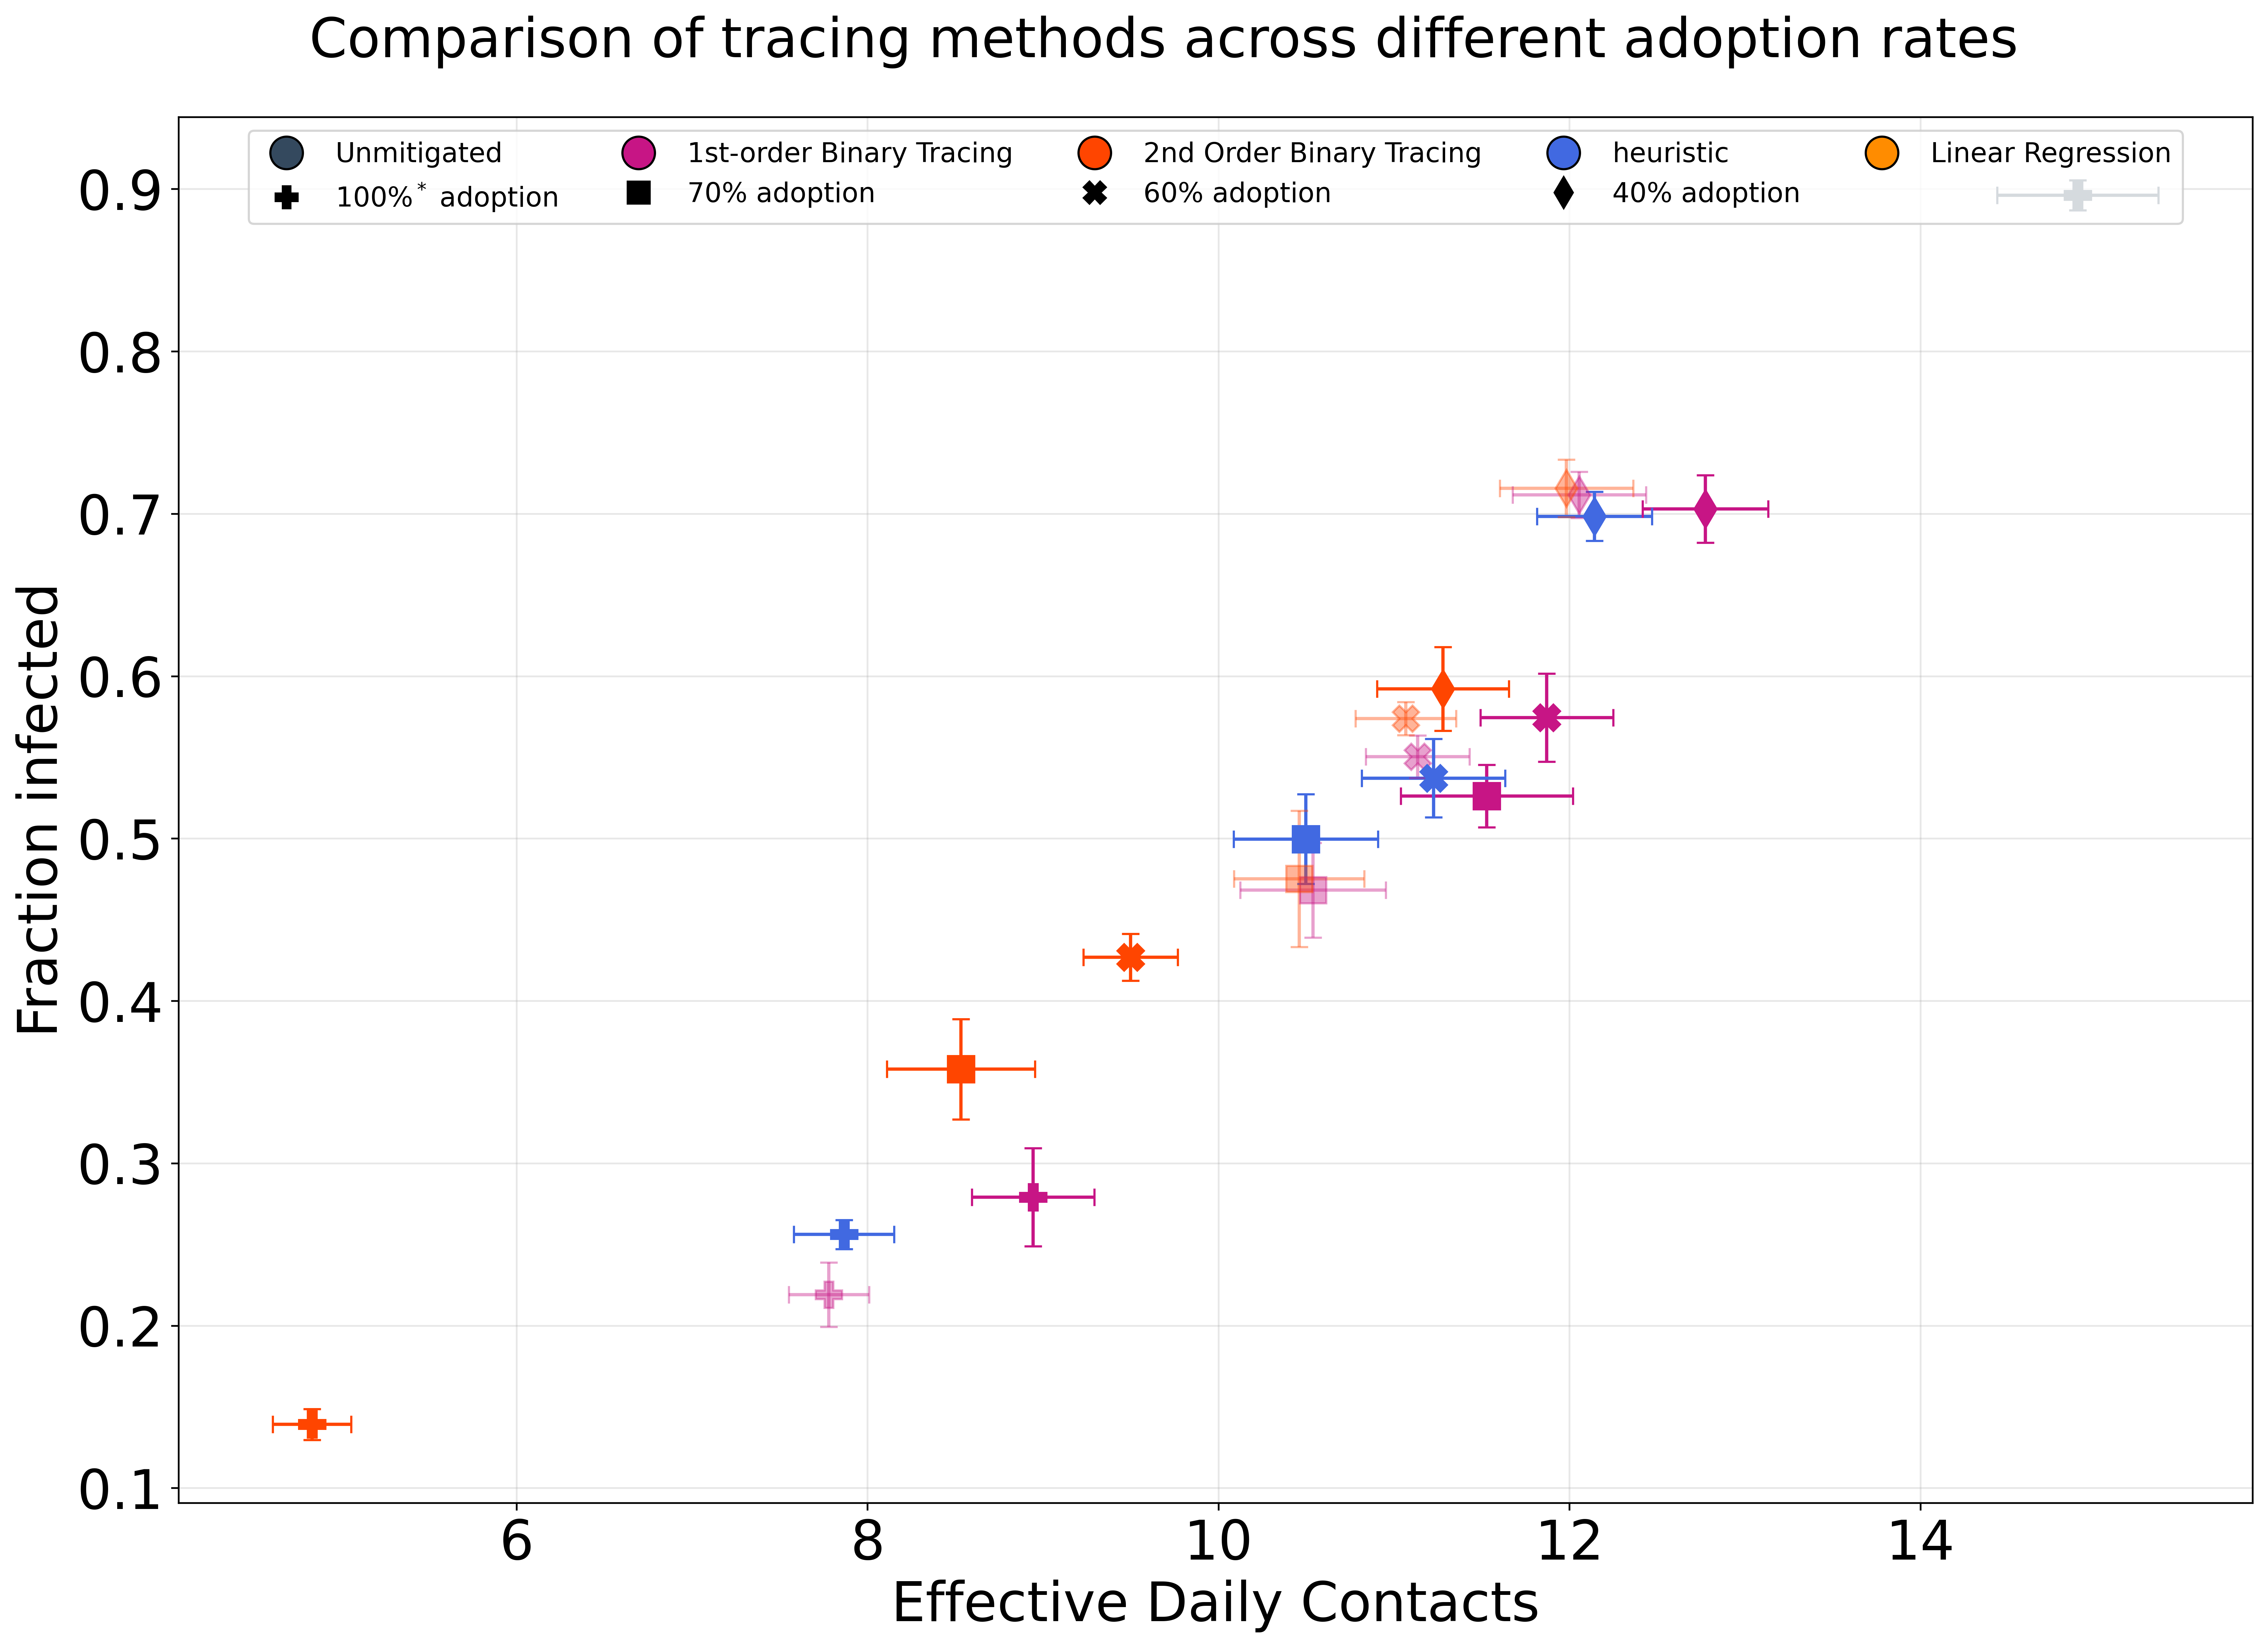

In [49]:
xmetric =  "effective_contacts" #"f1", "effective_contacts", "outside_daily_contacts", "f2", "f3", "f1_up", "f2_up"
ymetric = "percent_infected" # "percent_infected", "proxy_r", "r"

ms = 6*2
capsize = 4
markers = ['P', 's', 'X', 'd', '.']

colormap = ["#34495e",  "mediumvioletred", "orangered", "royalblue", "darkorange", "green", "red"]

fig, ax = plt.subplots(figsize=(15,10), dpi=500)

# unmitigated
idx = 0
x, xe = get_metrics(data, "unmitigated", xmetric)
y, ye = get_metrics(data, "unmitigated", ymetric)

ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                     capsize=capsize, c=colormap[idx], marker=markers[idx], ms=ms, label="unmitigated")


idx = 1
for i, label in enumerate(['bdt1', 'bdt1_70','bdt1_60', 'bdt1_40']):
    x, xe = get_metrics(data, label, xmetric)
    y, ye = get_metrics(data, label, ymetric)
    ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                     capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label)

idx = 1
for i, label in enumerate(['bdt1_norm', 'bdt1_70_norm','bdt1_60_norm', 'bdt1_40_norm']):
    x, xe = get_metrics(data, label, xmetric)
    y, ye = get_metrics(data, label, ymetric)
    ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                     capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label, alpha=0.4)

    
idx = 2
for i,label in enumerate(['bdt2', 'bdt2_70','bdt2_60', 'bdt2_40']):    
    x, xe = get_metrics(data, label, xmetric)
    y, ye = get_metrics(data, label, ymetric)
    ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                     capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label)

idx = 2
for i,label in enumerate(['bdt2_norm', 'bdt2_70_norm','bdt2_60_norm', 'bdt2_40_norm']):    
    x, xe = get_metrics(data, label, xmetric)
    y, ye = get_metrics(data, label, ymetric)
    ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                     capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label, alpha=0.4)
    
    
idx = 3
for i, label in enumerate(['heuristic', 'heuristic_70', 'heuristic_60', 'heuristic_40']):
    x, xe = get_metrics(data, label, xmetric)
    y, ye = get_metrics(data, label, ymetric)
    ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
                     capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label)

# idx = 3
# for i, label in enumerate(['transformer', 'transformer_70', 'transformer_60', 'transformer_40']):
#     x, xe = get_metrics(data, label, xmetric)
#     y, ye = get_metrics(data, label, ymetric)
#     ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
#                      capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label)

# idx = 3
# for i, label in enumerate(['transformerB_70', 'transformerB_60', 'transformerB_40']):
#     x, xe = get_metrics(data, label, xmetric)
#     y, ye = get_metrics(data, label, ymetric)
#     ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
#                      capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label)

# idx = 4
# for i, label in enumerate(['linear_70', 'linear_60', 'linear_40']):
#     x, xe = get_metrics(data, label, xmetric)
#     y, ye = get_metrics(data, label, ymetric)
#     ax.errorbar(x=x, y=y, xerr=xe, yerr=ye, linestyle = 'None',
#                      capsize=capsize, c=colormap[idx], marker=markers[i], ms=ms, label=label)
    
# legends 
legend = [
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='#34495e', markersize=15, label='Unmitigated'),
    Line2D([0], [0], color='none', lw=2, marker='P', markerfacecolor='black', markersize=10, label='100%$^*$ adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='mediumvioletred', markersize=15, label='1st-order Binary Tracing'),
    Line2D([0], [0], color='none', lw=2, marker='s', markerfacecolor='black', markersize=10, label='70% adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='orangered', markersize=15, label='2nd Order Binary Tracing'),
    Line2D([0], [0], color='none', lw=2, marker='X', markerfacecolor='black', markersize=10, label='60% adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='royalblue', markersize=15, label='heuristic'),
    Line2D([0], [0], color='none', lw=2, marker='d', markerfacecolor='black', markersize=10, label='40% adoption'),
    Line2D([0], [0], color='none', marker='o', markeredgecolor='k', markerfacecolor='darkorange', markersize=15, label='Linear Regression'),
]
ax.legend(handles=legend, loc='upper center', ncol=5, fontsize=12.5)

# grids 
ax.grid(True, axis='x', alpha=0.3)
ax.grid(True, axis='y', alpha=0.3)

plt.xticks(size=25)
plt.yticks(size=25)
# plt.xlabel('Fraction incorrectly quarantined',size=25)
if xmetric == "f3":
    plt.xlabel('False Quarantine',size=25)
elif xmetric == "effective_contacts":
    plt.xlabel('Effective Daily Contacts',size=25)
elif xmetric == "outside_daily_contacts":
    plt.xlabel('Outside Daily Contacts',size=25)

if ymetric == "percent_infected":
    plt.ylabel('Fraction infected', size=25)

elif ymetric == "proxy_r":
    ax.plot([0,1.0], [1.0, 1.0], '-.', c="gray", alpha=0.3, label='Rt = 1.0')
    plt.ylabel('Proxy $\hat{R_t}$', size=16)

elif ymetric == "r":
    ax.plot([0,1.0], [1.0, 1.0], '-.', c="gray", alpha=0.3, label='Rt = 1.0')
    plt.ylabel('$R_t$', size=16)

fig.suptitle("Comparison of tracing methods across different adoption rates", fontsize=25, y=1.05)

plt.tight_layout()


In [50]:
fig.savefig("normalized-pareto-adoption-effective_contacts-30")